In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')

In [2]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

#create linear svc pipeline with preprocessing
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LinearSVC(max_iter=100000, dual=False))])
#create parameter grid with differnt preprocessing and classification parameters
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler(), None],
              'classifier__C': [0.01, 0.1, 1, 10, 100]}
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [4]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [5]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [7]:
#grid search with shuffled k fold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LinearSVC(C=0.01, dual=False, max_iter=100000))])
grid_kfold_shuffle: best cross-validation score:  0.6873134328358208
grid_kfold_shuffle: test set average accuracy:  0.7017543859649122 



In [8]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.decision_function(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', LinearSVC(C=10, dual=False, max_iter=100000))])
grid_kfold_shuffle: best cross-validation score:  0.7015138603334985
grid_kfold_shuffle test set average precision:  0.6978973539655374 



In [9]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate AUC
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.decision_function(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', RobustScaler()),
                ('classifier', LinearSVC(C=0.01, dual=False, max_iter=100000))])
grid_kfold_shuffle: best cross-validation score:  0.7173099854818368
grid_kfold_shuffle test set AUC:  0.7447660098522167 



Text(0.5, 1.0, 'precision-recall curve for linearSVC (no preprocessing, c=100)')

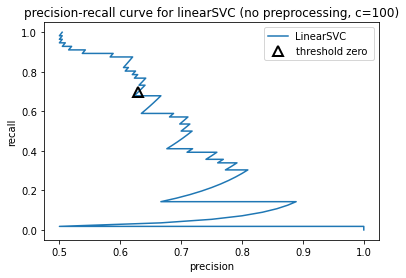

In [10]:
#use no preprocessing and best paramter (C=100) for av. precision
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np

pipe = Pipeline([('preprocessing', None), 
                 ('classifier', LinearSVC(C=0.1, max_iter=100000, dual=False))])

pipe.fit(X_train_cv, y_train_cv)

predict = (pipe.decision_function(X_test_cv))

precision, recall, thresholds = precision_recall_curve(y_test_cv, predict)

plt.plot(precision, recall, label='LinearSVC')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], '^', c='k', 
          markersize=10, label='threshold zero ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')
plt.title('precision-recall curve for linearSVC (no preprocessing, c=100)')

In [11]:
thresholds

array([-0.7074279 , -0.66957176, -0.65976756, -0.59767195, -0.59456953,
       -0.59129262, -0.59072515, -0.58386206, -0.57168194, -0.56572381,
       -0.54824844, -0.54339361, -0.5417094 , -0.53313076, -0.50343405,
       -0.50086594, -0.46429264, -0.44914542, -0.43114137, -0.43084737,
       -0.38051002, -0.35172272, -0.31835399, -0.28758413, -0.26308842,
       -0.26150332, -0.21593119, -0.21457197, -0.20816158, -0.19669937,
       -0.19270709, -0.18612863, -0.17344722, -0.10994877, -0.09489256,
       -0.0911068 , -0.09016724, -0.08441218, -0.08022332, -0.07695519,
       -0.07308024, -0.07099067, -0.05780192, -0.04741012, -0.03967766,
       -0.03600527, -0.03386717, -0.00870002, -0.00641355,  0.00338677,
        0.00624655,  0.01158103,  0.01458185,  0.01772877,  0.0199867 ,
        0.02139471,  0.03716584,  0.03990547,  0.0520423 ,  0.05329833,
        0.05468816,  0.06005742,  0.060156  ,  0.07337775,  0.09065972,
        0.1031051 ,  0.10424485,  0.10611142,  0.11360824,  0.11

Text(0.5, 1.0, 'ROC curve for linearSVC (no preprocessing, C=100)')

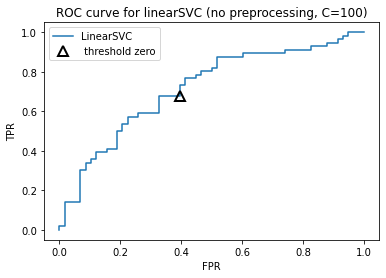

In [12]:
#use no preprocessing and best parameters (c=100) for av. precision

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_cv, pipe.decision_function(X_test_cv))

plt.plot(fpr, tpr, label='LinearSVC')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], '^', c='k',
         markersize=10, label=' threshold zero', fillstyle='none', mew=2)
plt.xlabel('FPR')
plt.ylabel('TPR')#roc curve for best average precision estimator
plt.legend(loc='best')
plt.title('ROC curve for linearSVC (no preprocessing, C=100)')

In [13]:
#confusion matrix (no preprocessing, c=100)

from sklearn.metrics import confusion_matrix

#build and fit pipeline
pipe = Pipeline([('preprocessing', None), 
                 ('classifier', LinearSVC(C=0.1, max_iter=100000, dual=False))])

pipe.fit(X_train_cv, y_train_cv)
predict = pipe.predict(X_test_cv).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_cv, predict)

#calculate precision, sensitivity, specificity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_cv[y_test_cv==0].count())*100
major_error = (confusion[1][0]/y_test_cv[y_test_cv==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.6290322580645161
Sensitivity:  0.6964285714285714
Specificity:  0.603448275862069
FPR : 0.39655172413793105
very major error : 39.6551724137931
major error:  30.357142857142854

 confusion matrix: 
 [[35 23]
 [17 39]]


In [14]:
# shift decision threshold - not good - produces more false susceptible predictions 
predict = (pipe.decision_function(X_test_cv)>0.4).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_cv, predict)

#calculate precision, sensitivity, specificity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_cv[y_test_cv==0].count())*100
major_error = (confusion[1][0]/y_test_cv[y_test_cv==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.8
Sensitivity:  0.2857142857142857
Specificity:  0.9310344827586207
FPR : 0.06896551724137934
very major error : 6.896551724137931
major error:  71.42857142857143

 confusion matrix: 
 [[54  4]
 [40 16]]


Indirect binary classification via multiclass MIC classification

In [15]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [16]:
# need code to clean up values > 1.6 - need to see if RF can use continuous data

MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_22432/380884722.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [17]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

In [18]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [19]:
# creates features and label dfs from unique mutations when the original train-test split 
# is inputted 
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #converts MIC_values to an integer so that the mean can be calculated for each mutation
    #with multiple samples
    MIC_integers = []

    for i in CV_train['MIC_VALUES']:
        if i == '<=0.025':
            MIC_integers.append(1)
        elif i == '0.05':
            MIC_integers.append(2)
        elif i == '0.1':
            MIC_integers.append(3)
        elif i == '0.2':
            MIC_integers.append(4)
        elif i == '0.4':
            MIC_integers.append(5)
        elif i == '0.8':
            MIC_integers.append(6)
        elif i == '1.6':
            MIC_integers.append(7)
        elif i == '>1.6':
            MIC_integers.append(8)
        
    CV_train['MIC_integers'] = MIC_integers

    #calculates the mean MIC value using the integer scale for each mutation
    MIC_calc_df = CV_train[['MUTATION','MIC_integers']].groupby('MUTATION').mean()
    
    #rounds the mean MIC value to the nearest integer for conversion back to the 
    #original MIC classes
    MIC_rounded = []
    for i in MIC_calc_df['MIC_integers']:
        rnd = round(i)
        MIC_rounded.append(rnd)
    MIC_calc_df['MIC_rounded'] = MIC_rounded
    
    #converts integers back to orignal MIC classes
    MIC_strings = []
    for i in MIC_calc_df['MIC_rounded']:
        if i == 1:
            MIC_strings.append('<=0.025')
        elif i == 2:
            MIC_strings.append('0.05')
        elif i == 3:
            MIC_strings.append('0.1')
        elif i == 4:
            MIC_strings.append('0.2')
        elif i == 5:
            MIC_strings.append('0.4')
        elif i == 6:
            MIC_strings.append('0.8')
        elif i == 7:
            MIC_strings.append('1.6')
        elif i == 8:
            MIC_strings.append('>1.6')   

    MIC_calc_df['MIC_final'] = MIC_strings

    # joins new MIC classes to CV_train df to replace the variation in MIC values associated
    # with mutations with multiple DST_measurements 
    MIC_calc_df.drop(['MIC_integers','MIC_rounded'], axis =1, inplace = True)
    CV_train.set_index('MUTATION', inplace = True)
    CV_train = CV_train.join(MIC_calc_df)
    CV_train.reset_index(inplace = True)
    CV_train.drop(['MIC_VALUES','MIC_integers'], axis = 1, inplace = True)
    CV_train.rename(columns = {'index':'MUTATION','MIC_final':'MIC_VALUES'}, inplace = True)
    
    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [20]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [22]:
#build pipeline and paratmeter grid (one vs rest)
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LinearSVC(max_iter=100000, dual=False))])
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler()],
              'classifier__C': [0.01, 0.1, 1, 10, 100]}

In [23]:
#Grid search with shuffled kfold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle, n_jobs=-1)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier', LinearSVC(C=0.01, dual=False, max_iter=100000))])
grid_kfold_shuffle: best cross-validation score:  0.18413793103448275
grid_kfold_shuffle: test set average accuracy:  0.22 



In [24]:
from sklearn.metrics import confusion_matrix

#build pipeline and fit
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', LinearSVC(C=0.01, max_iter=100000, dual=False))])

pipe.fit(X_train_cv, y_train_cv)                 
                 
predict = pipe.predict(X_test_nodup)
#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

print ('\n multiclass confusion matrix: \n', confusion)


 multiclass confusion matrix: 
 [[5 0 0 0 0 0 4 0]
 [2 0 1 1 1 0 4 3]
 [5 0 1 1 2 0 3 1]
 [0 0 0 1 1 0 2 4]
 [2 0 0 1 2 1 1 1]
 [0 0 0 0 2 0 0 2]
 [5 0 0 0 1 0 2 0]
 [5 0 1 1 1 1 1 3]]


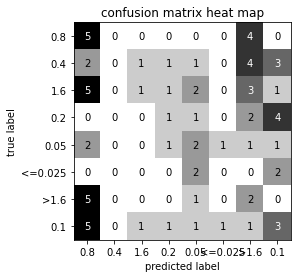

In [25]:
#generate heatmap of confusion matrix for visualisation

import mglearn

target_names = MIC_ML_data['MIC_values'].unique().tolist()
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix heat map')
plt.gca().invert_yaxis()

In [26]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

        0.05       0.21      0.56      0.30         9
         0.1       1.00      0.00      0.00        12
         0.2       0.33      0.08      0.12        13
         0.4       0.20      0.12      0.15         8
         0.8       0.20      0.25      0.22         8
         1.6       0.00      0.00      0.00         4
     <=0.025       0.12      0.25      0.16         8
        >1.6       0.21      0.23      0.22        13

    accuracy                           0.19        75
   macro avg       0.28      0.19      0.15        75
weighted avg       0.34      0.19      0.15        75



In [27]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {1:['0.2','0.4','0.8','1.6','>1.6'],
           0:['<=0.025','0.05','0.1']}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

In [28]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.7941176470588235
Sensitivity:  0.5869565217391305
Specificity:  0.7586206896551724
FPR : 0.24137931034482762
very major error : inf
major error:  inf

 confusion matrix: 
 [[22  7]
 [19 27]]


C:\Users\user\AppData\Local\Temp/ipykernel_22432/4269136536.py:9: RuntimeWarning: divide by zero encountered in longlong_scalars
  very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
C:\Users\user\AppData\Local\Temp/ipykernel_22432/4269136536.py:10: RuntimeWarning: divide by zero encountered in longlong_scalars
  major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


In [29]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.54      0.76      0.63        29
           1       0.79      0.59      0.68        46

    accuracy                           0.65        75
   macro avg       0.67      0.67      0.65        75
weighted avg       0.69      0.65      0.66        75

